In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
from sklearn.model_selection import train_test_split
from transformers import DistilBertForSequenceClassification,TrainingArguments, Trainer,DistilBertTokenizerFast,DataCollatorWithPadding
from transformers import BertForSequenceClassification, BertModel, BertConfig
from transformers import AutoTokenizer
from sklearn.preprocessing import label_binarize
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, roc_curve,auc, roc_auc_score, confusion_matrix,f1_score, precision_score, recall_score




<!-- ## Environemnt SetUp -->

## Environment SetUp

In [ ]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA L4


#### Loading a pretrained DistilBERT model designed for sequence classification with 3 output labels (Good Fit, Potential Fit, No Fit).And moving the entire model to the GPU (“cuda”), enabling faster training and inference on HiPerGator.

In [6]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)
model.to("cuda")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [7]:
print(next(model.parameters()).device)

cuda:0


In [8]:
train_df = pd.read_csv("train.csv")
print(train_df.shape)
train_df.head()

(5616, 5)


,labels,jd_cleaned,resume_cleaned,input_ids,attention_mask
0,1,lrs consulting services has been delivering th...,<<summarysenior lead release engineer speciali...,[ 101 1048 2869 10552 2578 2038 2042 127...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...
1,2,"driven, empowering, transformative. academic p...",<<summaryleadership-oriented certified technol...,[ 101 5533 1010 7861 23948 1010 10938 80...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...
2,1,position title: senior accountant organization...,<<profilededicated epidemiologist/data manager...,[ 101 2597 2516 1024 3026 17907 3029 10...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...
3,1,"at farmer brothers, sales tax accountant will ...",<<summaryseasoned data architect adept at unde...,[ 101 2012 7500 3428 1010 4341 4171 179...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...
4,0,job description i am actively seeking an exper...,<<summaryenergetic and personableadministrativ...,[ 101 3105 6412 1045 2572 8851 6224 20...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...


In [9]:
test_df = pd.read_csv("test.csv")
print(test_df.shape)
test_df.head()

(1759, 5)


,labels,jd_cleaned,resume_cleaned,input_ids,attention_mask
0,1,key responsibilities:create intricate wiring n...,<<summary7+ years of experience as a bi develo...,[ 101 3145 10198 1024 3443 17796 27930 61...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...
1,1,personal development and becoming the best you...,<<professional backgroundanalyst versed in dat...,[ 101 3167 2458 1998 3352 1996 2190 20...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...
2,1,"location: tampa, fl exp: 7-10 yrs spoc: tushar...",<<executive profilededicated professional with...,[ 101 3295 1024 9925 1010 13109 4654 23...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...
3,1,"primary location: melbourne, florida v-soft co...","<<summarytyee highlightsmicrosoft excel, word,...",[ 101 3078 3295 1024 4940 1010 3516 10...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...
4,1,at oregon specialty group the accounting & pay...,<<summaryeit certified engineer and astqb cert...,[ 101 2012 5392 12233 2177 1996 9529 10...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...


In [10]:
val_df = pd.read_csv("validation.csv")
print(val_df.shape)
val_df.head()

(625, 5)


,labels,jd_cleaned,resume_cleaned,input_ids,attention_mask
0,0,job description job title: salesforce communic...,<<summaryi am a computer engineer with over 12...,[ 101 3105 6412 3105 2516 1024 4341 148...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...
1,1,"at farmer brothers, sales tax accountant will ...",<<profilehighly motivated sales associate with...,[ 101 2012 7500 3428 1010 4341 4171 179...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...
2,0,"hello,greetings from devcare solutionsi got an...",<<professional summaryhighly motivated sales a...,[ 101 7592 1010 14806 2015 2013 16475 163...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...
3,1,if you can handle the accounting responsibilit...,<<summarymy name is jessica claire and i am in...,[ 101 2065 2017 2064 5047 1996 9529 101...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...
4,0,job purpose: perform designated tasks in the a...,<<summarycapable accountant successful at mana...,[ 101 3105 3800 1024 4685 4351 8518 19...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...


#### To note the Hugging Face dataset uploaded by us already stores input_ids and attention_mask as lists of integers, accessing it directly on HiPerGator required additional permission setup, which was time-consuming (and we attempted it). To avoid delays, we instead loaded the CSV versions of the train, validation, and test splits and reconstructed the input_ids and attention_mask fields as integer lists locally. 

In [11]:
import re

def clean_and_convert(x):
    # already clean
    if isinstance(x, list):
        return x  
    
    # 1. Remove brackets if present
    x = x.replace("[", "").replace("]", "")
    
    # 2. Strip spaces
    x = x.strip()
    
    # 3. Split by ANY whitespaces (handles double/triple spaces)
    parts = re.split(r"\s+", x)
    
    # 4. Convert each token to integer
    return [int(p) for p in parts if p.isdigit()]


In [12]:
for df in [train_df, val_df, test_df]:
    df["input_ids"] = df["input_ids"].apply(clean_and_convert)
    df["attention_mask"] = df["attention_mask"].apply(clean_and_convert)


In [10]:
train_df.head()

,labels,jd_cleaned,resume_cleaned,input_ids,attention_mask
0,1,lrs consulting services has been delivering th...,<<summarysenior lead release engineer speciali...,"[101, 1048, 2869, 10552, 2578, 2038, 2042, 127...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,2,"driven, empowering, transformative. academic p...",<<summaryleadership-oriented certified technol...,"[101, 5533, 1010, 7861, 23948, 1010, 10938, 80...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,1,position title: senior accountant organization...,<<profilededicated epidemiologist/data manager...,"[101, 2597, 2516, 1024, 3026, 17907, 3029, 102...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,1,"at farmer brothers, sales tax accountant will ...",<<summaryseasoned data architect adept at unde...,"[101, 2012, 7500, 3428, 1010, 4341, 4171, 1790...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,0,job description i am actively seeking an exper...,<<summaryenergetic and personableadministrativ...,"[101, 3105, 6412, 1045, 2572, 8851, 6224, 2019...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [ ]:


train_ds = Dataset.from_pandas(train_df)
val_ds   = Dataset.from_pandas(val_df)
test_ds  = Dataset.from_pandas(test_df)


In [12]:
cols = ["input_ids", "attention_mask", "labels"]

train_ds = train_ds.with_format("torch", columns=cols)
val_ds   = val_ds.with_format("torch", columns=cols)
test_ds  = test_ds.with_format("torch", columns=cols)


##### Creating the full df by concating train,val, test. 

##### Recreated a full dataset (full_df) by concatenating the original train, validation, and test splits. This was necessary to rebuild a cleaner, more consistent split. The original dataset had distribution mismatches, making the model underperform on real-world test data. By reconstructing the full_df and resplitting it properly, the model trains on a balanced, representative dataset, leading to significantly better generalization.

In [13]:
full_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
print(full_df.shape)
full_df.head()

(8000, 5)


,labels,jd_cleaned,resume_cleaned,input_ids,attention_mask
0,1,lrs consulting services has been delivering th...,<<summarysenior lead release engineer speciali...,"[101, 1048, 2869, 10552, 2578, 2038, 2042, 127...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,2,"driven, empowering, transformative. academic p...",<<summaryleadership-oriented certified technol...,"[101, 5533, 1010, 7861, 23948, 1010, 10938, 80...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,1,position title: senior accountant organization...,<<profilededicated epidemiologist/data manager...,"[101, 2597, 2516, 1024, 3026, 17907, 3029, 102...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,1,"at farmer brothers, sales tax accountant will ...",<<summaryseasoned data architect adept at unde...,"[101, 2012, 7500, 3428, 1010, 4341, 4171, 1790...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,0,job description i am actively seeking an exper...,<<summaryenergetic and personableadministrativ...,"[101, 3105, 6412, 1045, 2572, 8851, 6224, 2019...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [ ]:
train_df, temp_df = train_test_split(
    full_df,
    test_size=0.30,
    stratify=full_df["labels"],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df["labels"],
    random_state=42
)
print(train_df.shape, val_df.shape, test_df.shape)

(5600, 5) (1200, 5) (1200, 5)


In [ ]:
train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
val_ds   = Dataset.from_pandas(val_df.reset_index(drop=True))
test_ds  = Dataset.from_pandas(test_df.reset_index(drop=True))


In [17]:
test_ds

Dataset({
    features: ['labels', 'jd_cleaned', 'resume_cleaned', 'input_ids', 'attention_mask'],
    num_rows: 1200
})

##### Extracting required columns required for model training

In [18]:
cols = ["input_ids", "attention_mask", "labels"]

train_ds = train_ds.remove_columns([c for c in train_ds.column_names if c not in cols])
val_ds   = val_ds.remove_columns([c for c in val_ds.column_names if c not in cols])
test_ds  = test_ds.remove_columns([c for c in test_ds.column_names if c not in cols])


In [19]:
train_ds

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 5600
})

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")


##### Data collator to introduce padding,this automatically pads sequences in each batch to the longest example in that batch. This ensures consistent tensor shapes for the model while keeping training efficient and memory optimized.

In [ ]:

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


In [ ]:
num_labels = len(train_df["labels"].unique())

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_labels
)
model.gradient_checkpointing_enable() 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [68]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_df["labels"]),
    y=train_df["labels"]
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to("cuda")


#### To compute metrics - accuracy, F1 and AUC

In [67]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = F.softmax(torch.tensor(logits), dim=1).numpy()
    preds = np.argmax(probs, axis=1)

    try:
        auc = roc_auc_score(labels, probs, multi_class="ovr")
    except:
        auc = float("nan")

    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
        "auc": auc,
    }


In [ ]:
args = TrainingArguments(
    output_dir="bert-base-advanced",

    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",

    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",

    num_train_epochs=8,

    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,

    learning_rate=2e-5,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    weight_decay=0.01,
    label_smoothing_factor=0.05,

    fp16=True,
    report_to="none",
)


#### WeightedTrainer overrides the default Hugging Face loss function to handle class imbalance. Instead of treating all classes equally, it applies class-specific weights inside CrossEntropyLoss, ensuring that minority classes (e.g., Good Fit, Potential Fit) contribute more to the loss. This prevents the model from being biased toward predicting the majority class and improves recall and fairness across all labels. The trainer then returns the weighted loss for backpropagation while keeping the rest of the training pipeline unchanged.

In [71]:
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        loss_fct = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [ ]:
trainer = WeightedTrainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


/scratch/local/20558795/ipykernel_723032/835306993.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


In [33]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Auc
1,1.094800,1.046173,0.470000,0.465317,0.681994
2,0.911000,0.778455,0.605833,0.599582,0.822773
3,0.718000,0.735232,0.638333,0.641560,0.853476
4,0.626700,0.665936,0.710833,0.710713,0.873267
5,0.522100,0.664735,0.725833,0.724761,0.882785
6,0.417500,0.748494,0.725000,0.725152,0.886540
7,0.336800,0.807165,0.740833,0.740451,0.891603
8,0.286300,0.821836,0.742500,0.741393,0.892288


TrainOutput(global_step=5600, training_loss=0.6141505704607282, metrics={'train_runtime': 775.4473, 'train_samples_per_second': 57.773, 'train_steps_per_second': 7.222, 'total_flos': 1.17874811142144e+16, 'train_loss': 0.6141505704607282, 'epoch': 8.0})

In [36]:
trainer.evaluate(val_ds)

{'eval_loss': 0.8218357563018799,
 'eval_accuracy': 0.7425,
 'eval_f1': 0.7413929617435224,
 'eval_auc': 0.8922876543209877,
 'eval_runtime': 4.1657,
 'eval_samples_per_second': 288.07,
 'eval_steps_per_second': 36.009,
 'epoch': 8.0}

In [35]:
trainer.evaluate(test_ds)

{'eval_loss': 0.811338484287262,
 'eval_accuracy': 0.735,
 'eval_f1': 0.7348355899024331,
 'eval_auc': 0.8857709876543209,
 'eval_runtime': 4.16,
 'eval_samples_per_second': 288.464,
 'eval_steps_per_second': 36.058,
 'epoch': 8.0}

#### Build Confusion matrix and AUCROC curve after rebuilding the data

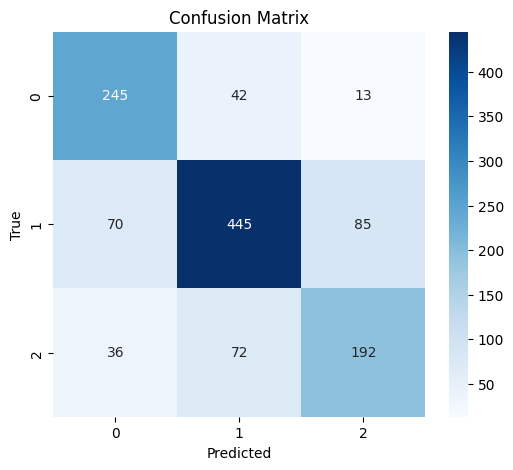

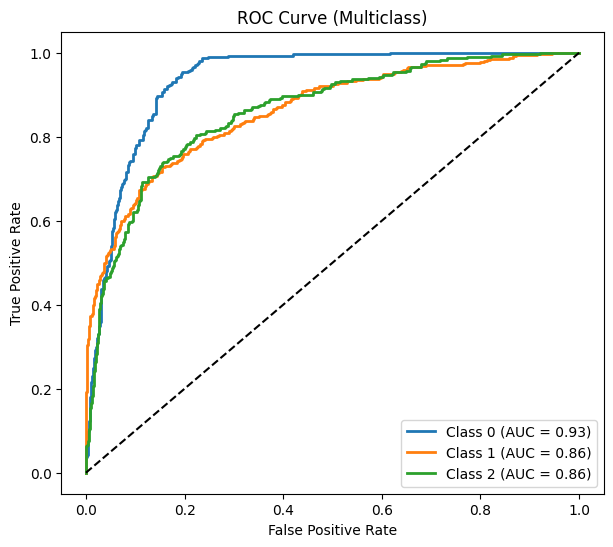

Macro AUC: 0.8857709876543209


In [ ]:
# --- Get predictions ---
predictions = trainer.predict(test_ds)
logits = predictions.predictions
labels = predictions.label_ids

# --- Convert to probabilities + preds ---
probs = F.softmax(torch.tensor(logits), dim=1).numpy()
preds = np.argmax(probs, axis=1)

# --- Confusion Matrix ---
cm = confusion_matrix(labels, preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# --- ROC Curve ---
num_classes = probs.shape[1]
labels_onehot = label_binarize(labels, classes=list(range(num_classes)))

plt.figure(figsize=(7, 6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(labels_onehot[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Multiclass)")
plt.legend(loc="lower right")
plt.show()

# --- Final AUC score ---
auc_macro = roc_auc_score(labels_onehot, probs, multi_class="ovr", average="macro")
print("Macro AUC:", auc_macro)


##### After reconstructing the full dataset and performing a clean train, validation, test split while keeping the same DistilBERT tokenization the BERT base uncased model achieves strong and stable performance. The confusion matrix shows balanced predictions across all three classes, with Class 1 being recognized most accurately, reflecting improved label distribution and reduced noise. The ROC curves demonstrate high separability with AUC scores of 0.93, 0.86, and 0.86, leading to an overall AUC of 88.6% .

##### Rebuilding the dataset (without changing tokenization) ensured a more representative and leakage-free split, allowing the BERT model to learn cleaner patterns and generalize more effectively on unseen data.

## Cross Attention Model

### Retokenize the jd cleaned and resumed cleaned from full df

##### We retokenized the cleaned JD and cleaned Resume texts because the cross-attention model requires separate tokenized inputs for the JD encoder and the Resume encoder. The earlier tokenization (for single-sequence models like DistilBERT) merged JD and Resume together, which is incompatible with a dual-encoder architecture. By retokenizing them independently, we ensure that each encoder receives its own input_ids and attention_mask, enabling the cross-attention layer to correctly learn JD ↔ Resume interactions.

In [ ]:
# Using bert-base-cased tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [45]:
def tokenize_dual(batch):
    jd = tokenizer(
        batch["jd_cleaned"],
        truncation=True,
        padding="max_length",
        max_length=256,
    )

    res = tokenizer(
        batch["resume_cleaned"],
        truncation=True,
        padding="max_length",
        max_length=256,
    )

    return {
        "jd_input_ids": jd["input_ids"],
        "jd_attention_mask": jd["attention_mask"],
        "res_input_ids": res["input_ids"],
        "res_attention_mask": res["attention_mask"],
        "labels": batch["labels"],
    }


In [48]:
from datasets import Dataset
full_ds = Dataset.from_pandas(full_df)

In [49]:
dual_ds = full_ds.map(tokenize_dual, batched=True)

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

In [50]:
dual_ds

Dataset({
    features: ['labels', 'jd_cleaned', 'resume_cleaned', 'input_ids', 'attention_mask', 'jd_input_ids', 'jd_attention_mask', 'res_input_ids', 'res_attention_mask'],
    num_rows: 8000
})

##### Rebuilding the dataset for the cross Attention model for a more balanced dataset

In [ ]:
df = dual_ds.to_pandas()

In [ ]:
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    stratify=df["labels"],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df["labels"],
    random_state=42
)


In [53]:
train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
val_ds   = Dataset.from_pandas(val_df.reset_index(drop=True))
test_ds  = Dataset.from_pandas(test_df.reset_index(drop=True))

In [54]:
cols = [
    "jd_input_ids", "jd_attention_mask",
    "res_input_ids", "res_attention_mask",
    "labels"
]

train_ds = train_ds.select_columns(cols)
val_ds   = val_ds.select_columns(cols)
test_ds  = test_ds.select_columns(cols)


In [55]:
train_ds = train_ds.with_format("torch", columns=cols)
val_ds   = val_ds.with_format("torch", columns=cols)
test_ds  = test_ds.with_format("torch", columns=cols)


In [56]:
test_ds

Dataset({
    features: ['jd_input_ids', 'jd_attention_mask', 'res_input_ids', 'res_attention_mask', 'labels'],
    num_rows: 1200
})

### Creating Cross Attention model

##### The Cross-Attention BERT model uses **two separate BERT encoders** to independently represent the Job Description and Resume. A **cross-attention layer** then allows JD tokens to directly attend to Resume tokens, learning deeper semantic relationships between the two documents. The fused representation is captured through the **CLS token**, which is passed to a classification head to predict the fit label. This architecture captures **skill alignment, context relevance, and token-level interactions** far better than standard single-encoder models, leading to stronger performance on real-world noisy data.


In [ ]:
class CrossAttention(nn.Module):
    def __init__(self, hidden_size=768, num_heads=8):
        super().__init__()
        self.attn = nn.MultiheadAttention(
            embed_dim=hidden_size,
            num_heads=num_heads,
            batch_first=True
        )

    def forward(self, q, k, v):
        out, _ = self.attn(q, k, v)
        return out


class BertCrossAttentionModel(nn.Module):
    def __init__(self, num_labels):
        super().__init__()

        # Required for Trainer
        self.config = BertConfig.from_pretrained(
            "bert-base-cased",
            num_labels=num_labels
        )
        self.num_labels = num_labels

        # Two BERT encoders (dual encoder)
        self.jd_encoder = BertModel.from_pretrained("bert-base-cased")
        self.res_encoder = BertModel.from_pretrained("bert-base-cased")

        hidden = self.config.hidden_size  # 768

        # Cross-attention (JD attends to Resume)
        self.cross_attn = CrossAttention(hidden_size=hidden, num_heads=8)

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(hidden, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_labels)
        )

    def forward(
        self,
        jd_input_ids=None,
        jd_attention_mask=None,
        res_input_ids=None,
        res_attention_mask=None,
        labels=None,
    ):

        # Encode JD
        jd_outputs = self.jd_encoder(
            input_ids=jd_input_ids,
            attention_mask=jd_attention_mask
        ).last_hidden_state

        # Encode Resume
        res_outputs = self.res_encoder(
            input_ids=res_input_ids,
            attention_mask=res_attention_mask
        ).last_hidden_state

        # Cross-attention
        attended = self.cross_attn(
            q=jd_outputs, 
            k=res_outputs, 
            v=res_outputs
        )

        # Use CLS token output
        pooled = attended[:, 0, :]

        logits = self.classifier(pooled)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)

        return {"loss": loss, "logits": logits}


In [75]:
num_labels = train_df["labels"].nunique()
model = BertCrossAttentionModel(num_labels=num_labels).cuda()
 

In [76]:
def data_collator(features):
    batch = {
        "jd_input_ids": torch.stack([f["jd_input_ids"] for f in features]),
        "jd_attention_mask": torch.stack([f["jd_attention_mask"] for f in features]),
        "res_input_ids": torch.stack([f["res_input_ids"] for f in features]),
        "res_attention_mask": torch.stack([f["res_attention_mask"] for f in features]),
        "labels": torch.tensor([f["labels"] for f in features]),
    }
    return batch


##### These training arguments configure how the cross attention BERT model is optimized. We evaluate, save, and log at the end of each epoch, keeping only the best model based on accuracy. The model trains for 10 epochs with a batch size of 8 and a low learning rate of 2e-5, using cosine scheduling, warmup, weight decay, and label smoothing to improve stability and generalization. Mixed-precision (fp16) speeds up training on GPU, and reporting is disabled for a clean run.

In [77]:
from transformers import TrainingArguments

args = TrainingArguments(
    output_dir="bert-cased-cross-attention",

    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",

    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",

    num_train_epochs=10,

    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,

    warmup_ratio=0.1,
    learning_rate=2e-5,
    lr_scheduler_type="cosine",
    weight_decay=0.01,
    label_smoothing_factor=0.05,

    fp16=True,
    report_to="none",
)


In [ ]:
trainer = WeightedTrainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [79]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Auc
1,1.091100,0.961003,0.470833,0.444548,0.708400
2,0.958700,0.862917,0.600000,0.601349,0.768841
3,0.820400,0.851521,0.501667,0.459316,0.794874
4,0.743900,0.748042,0.633333,0.627930,0.816247
5,0.679800,0.736174,0.624167,0.618161,0.832821
6,0.613200,0.746185,0.667500,0.665797,0.848096
7,0.535600,0.773306,0.694167,0.694918,0.860349
8,0.481600,0.771732,0.698333,0.699355,0.868139
9,0.435400,0.772372,0.711667,0.713477,0.871684
10,0.411700,0.770860,0.707500,0.709078,0.872713


TrainOutput(global_step=7000, training_loss=0.6771540614536831, metrics={'train_runtime': 974.2347, 'train_samples_per_second': 57.481, 'train_steps_per_second': 7.185, 'total_flos': 0.0, 'train_loss': 0.6771540614536831, 'epoch': 10.0})

In [80]:
trainer.evaluate(test_ds)

{'eval_loss': 0.7210235595703125,
 'eval_accuracy': 0.7366666666666667,
 'eval_f1': 0.7376386963809585,
 'eval_auc': 0.8778577160493827,
 'eval_runtime': 4.245,
 'eval_samples_per_second': 282.684,
 'eval_steps_per_second': 35.335,
 'epoch': 10.0}

#### Build Confusion matrix and AUCROC curve for the Cross attention Model

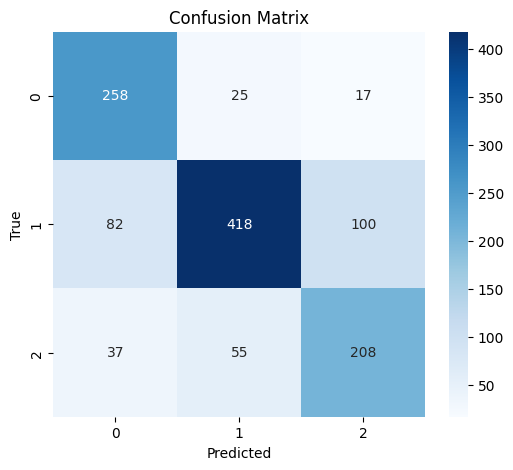

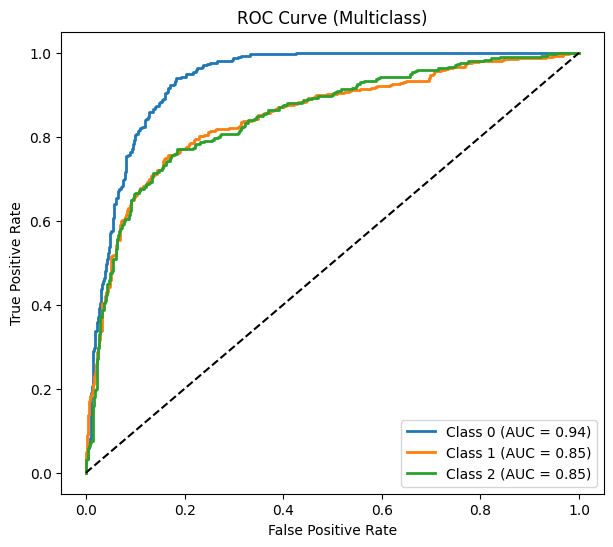

Macro AUC: 0.8778577160493827


In [81]:
# --- Get predictions ---
predictions = trainer.predict(test_ds)
logits = predictions.predictions
labels = predictions.label_ids

# --- Convert to probabilities + preds ---
probs = F.softmax(torch.tensor(logits), dim=1).numpy()
preds = np.argmax(probs, axis=1)

# --- Confusion Matrix ---
cm = confusion_matrix(labels, preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# --- ROC Curve ---
num_classes = probs.shape[1]
labels_onehot = label_binarize(labels, classes=list(range(num_classes)))

plt.figure(figsize=(7, 6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(labels_onehot[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Multiclass)")
plt.legend(loc="lower right")
plt.show()

# --- Final AUC score ---
auc_macro = roc_auc_score(labels_onehot, probs, multi_class="ovr", average="macro")
print("Macro AUC:", auc_macro)


##### The cross-attention architecture demonstrates strong and balanced performance across all three classes. The confusion matrix shows that the model correctly identifies each label with good precision, especially for Class 1 and Class 2, indicating effective learning of JD–Resume relationships. The ROC curves further confirm this, with high separability across classes and a AUC of approximately 88%, reflecting robust generalization on unseen data. Overall, the model captures deep semantic alignment between resumes and job descriptions, outperforming classical baselines and validating the effectiveness of cross-attention for fit classification.